In [30]:
import torch
import numpy as np
from sklearn.datasets import fetch_20newsgroups
import string
import re
from collections import Counter
import sys
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm, tqdm_notebook
from torch.optim import lr_scheduler
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
sys.path.append("D:/pdf_classifier")
from text_preprocessing import tokenize_long_text

In [3]:
newsgroups_train = fetch_20newsgroups(subset='train')

In [4]:
newsgroups_test = fetch_20newsgroups(subset='test')

In [32]:
max_tokens = 10000
output_sequence_length = 200 + 1
lstm_units1 = 256
lstm_units2 = 128
dense_units = 256
dropout = 0.7
dropout1 = 0.7
num_classes = 20

In [33]:
def create_vocab(dataset):
    vocab = {"<PAD>": 0, "<UNK>": 1} 
    
    counter = Counter()
    
    for text in dataset:
        tokens = re.sub(f"([{string.punctuation}])", r'', text).lower().split()
        counter.update(tokens)
        
    top_tokens = counter.most_common(max_tokens - 2) 
    
    for t in top_tokens:
        vocab[t[0]] = len(vocab)
        
    return vocab

In [34]:
vocab = create_vocab(newsgroups_train.data)

In [35]:
def text_tokenization(dataset, vocab, output_sequence_length):
    res = []
    for text in dataset:
        tokens = re.sub(f"([{string.punctuation}])", r'', text).lower().split()
        tokens_int = [vocab["<PAD>"]] * output_sequence_length
        for i in range (min(output_sequence_length, len(tokens))):
            if tokens[i] in vocab:
                tokens_int[i] = vocab[tokens[i]]
            else:
                tokens_int[i] = vocab["<UNK>"]
        res.append(tokens_int)
    return res

In [36]:
newsgroups_train_tokenized = text_tokenization(newsgroups_train.data, vocab, output_sequence_length)

In [37]:
X = np.array(newsgroups_train_tokenized)
y = np.array(newsgroups_train.target)
X_tensor = torch.tensor(X, dtype=torch.float32) 
y_tensor = torch.tensor(y, dtype=torch.long)

In [38]:
newsgroups_test_tokenized = text_tokenization(newsgroups_test.data, vocab, output_sequence_length)

In [39]:
X_t = np.array(newsgroups_test_tokenized)
y_t  = np.array(newsgroups_test.target)

In [40]:
X_t_tensor = torch.tensor(X_t, dtype=torch.float32) 
y_t_tensor = torch.tensor(y_t, dtype=torch.long)

In [41]:
dataset = TensorDataset(X_tensor, y_tensor)


In [42]:
test_dataset = TensorDataset(X_t_tensor, y_t_tensor)

In [43]:
class MyModel(nn.Module):
    def __init__(self, max_tokens, embedding_dim, lstm_units1, lstm_units2, dense_units, dropout, dropout1, num_classes):
        super(MyModel, self).__init__()
        
        self.embedding = nn.Embedding(num_embeddings=max_tokens, embedding_dim=embedding_dim, padding_idx=0)
        
        self.lstm1 = nn.LSTM(input_size=embedding_dim, hidden_size=lstm_units1, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(input_size=2*lstm_units1, hidden_size=lstm_units2, batch_first=True, bidirectional=True)
        
        self.dropout = nn.Dropout(dropout)
        self.dropout1 = nn.Dropout(dropout1)
        
        self.fc = nn.Linear(2*lstm_units2, dense_units)
        self.out = nn.Linear(dense_units, num_classes)
        
    def forward(self, x):
        x = x.long()
        x = self.embedding(x)  
        
        x, _ = self.lstm1(x)   
        x, _ = self.lstm2(x)   
        
        x = x[:, -1, :]  
        
        x = self.dropout(x)
        x = F.relu(self.fc(x))
        x = self.dropout1(x)
        x = self.out(x)
        
        return x


In [44]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [45]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [46]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_files, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_files, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    
    best_val_loss = float('inf')
    
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(), lr=1e-3) #AdamW вместо Adam
        exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=10, gamma=0.1)  #меняем learning rate 
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), "best_model.pth") 
                tqdm.write(f"Best model saved at epoch {epoch+1} with val_loss={val_loss:.4f}")
                
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [47]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [48]:
DEVICE = torch.device("cuda")

In [49]:
model = MyModel(max_tokens, output_sequence_length, lstm_units1, lstm_units2, dense_units, dropout, dropout1, num_classes).to(DEVICE)

In [50]:
model = model.to(DEVICE)

In [51]:
history = train(dataset, test_dataset, model=model, epochs=30, batch_size=8)

epoch:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]

loss 2.998625817770079


epoch:   3%|██▌                                                                         | 1/30 [00:49<24:02, 49.73s/it]

Best model saved at epoch 1 with val_loss=2.9853

Epoch 001 train_loss: 2.9986     val_loss 2.9853 train_acc 0.0566 val_acc 0.0645
loss 2.9649097244710454


epoch:   7%|█████                                                                       | 2/30 [01:40<23:32, 50.44s/it]

Best model saved at epoch 2 with val_loss=2.8773

Epoch 002 train_loss: 2.9649     val_loss 2.8773 train_acc 0.0622 val_acc 0.0982
loss 2.929917547081982


epoch:  10%|███████▌                                                                    | 3/30 [02:25<21:31, 47.85s/it]

Best model saved at epoch 3 with val_loss=2.7570

Epoch 003 train_loss: 2.9299     val_loss 2.7570 train_acc 0.0704 val_acc 0.1025
loss 2.6697662885226565


epoch:  13%|██████████▏                                                                 | 4/30 [03:16<21:18, 49.19s/it]

Best model saved at epoch 4 with val_loss=2.5596

Epoch 004 train_loss: 2.6698     val_loss 2.5596 train_acc 0.1013 val_acc 0.1268
loss 2.4407570917993673


epoch:  17%|████████████▋                                                               | 5/30 [04:07<20:45, 49.80s/it]

Best model saved at epoch 5 with val_loss=2.4143

Epoch 005 train_loss: 2.4408     val_loss 2.4143 train_acc 0.1318 val_acc 0.1441
loss 2.2123498195933435


epoch:  20%|███████████████▏                                                            | 6/30 [04:58<20:03, 50.16s/it]

Best model saved at epoch 6 with val_loss=2.2745

Epoch 006 train_loss: 2.2123     val_loss 2.2745 train_acc 0.1508 val_acc 0.1666
loss 2.0989843772792427


epoch:  23%|█████████████████▋                                                          | 7/30 [05:49<19:18, 50.37s/it]

Best model saved at epoch 7 with val_loss=2.2389

Epoch 007 train_loss: 2.0990     val_loss 2.2389 train_acc 0.1715 val_acc 0.1665
loss 1.968686106602421


epoch:  27%|████████████████████▎                                                       | 8/30 [06:39<18:26, 50.28s/it]

Best model saved at epoch 8 with val_loss=2.1422

Epoch 008 train_loss: 1.9687     val_loss 2.1422 train_acc 0.2131 val_acc 0.2212
loss 1.781681376715652


epoch:  30%|██████████████████████▊                                                     | 9/30 [07:30<17:41, 50.53s/it]

Best model saved at epoch 9 with val_loss=2.0250

Epoch 009 train_loss: 1.7817     val_loss 2.0250 train_acc 0.2748 val_acc 0.2735
loss 1.5685834352342574


epoch:  33%|█████████████████████████                                                  | 10/30 [08:23<17:07, 51.37s/it]

Best model saved at epoch 10 with val_loss=1.9680

Epoch 010 train_loss: 1.5686     val_loss 1.9680 train_acc 0.3310 val_acc 0.3258
loss 1.4129113562013944


epoch:  37%|███████████████████████████▍                                               | 11/30 [09:14<16:15, 51.32s/it]

Best model saved at epoch 11 with val_loss=1.9312

Epoch 011 train_loss: 1.4129     val_loss 1.9312 train_acc 0.3885 val_acc 0.3375
loss 1.2498367336164289


epoch:  40%|██████████████████████████████                                             | 12/30 [10:04<15:14, 50.81s/it]


Epoch 012 train_loss: 1.2498     val_loss 1.9868 train_acc 0.4533 val_acc 0.3938
loss 1.105540447675952


epoch:  43%|████████████████████████████████▌                                          | 13/30 [10:52<14:08, 49.91s/it]

Best model saved at epoch 13 with val_loss=1.8160

Epoch 013 train_loss: 1.1055     val_loss 1.8160 train_acc 0.5232 val_acc 0.4529
loss 0.9534886833230936


epoch:  47%|███████████████████████████████████                                        | 14/30 [11:41<13:14, 49.64s/it]


Epoch 014 train_loss: 0.9535     val_loss 1.9015 train_acc 0.5970 val_acc 0.4903
loss 0.8281301169986962


epoch:  50%|█████████████████████████████████████▌                                     | 15/30 [12:31<12:24, 49.66s/it]


Epoch 015 train_loss: 0.8281     val_loss 1.8299 train_acc 0.6612 val_acc 0.5000
loss 0.6994297807189671


epoch:  53%|████████████████████████████████████████                                   | 16/30 [13:19<11:28, 49.15s/it]


Epoch 016 train_loss: 0.6994     val_loss 1.8660 train_acc 0.7203 val_acc 0.5409
loss 0.6360352136035342


epoch:  57%|██████████████████████████████████████████▌                                | 17/30 [14:06<10:32, 48.67s/it]


Epoch 017 train_loss: 0.6360     val_loss 1.9332 train_acc 0.7484 val_acc 0.5446
loss 0.5403463820467028


epoch:  60%|█████████████████████████████████████████████                              | 18/30 [14:54<09:42, 48.56s/it]


Epoch 018 train_loss: 0.5403     val_loss 1.9439 train_acc 0.7855 val_acc 0.5848
loss 0.47159355913118917


epoch:  63%|███████████████████████████████████████████████▌                           | 19/30 [15:43<08:54, 48.55s/it]

Best model saved at epoch 19 with val_loss=1.7835

Epoch 019 train_loss: 0.4716     val_loss 1.7835 train_acc 0.8283 val_acc 0.5899
loss 0.39377103696551896


epoch:  67%|██████████████████████████████████████████████████                         | 20/30 [16:32<08:08, 48.82s/it]


Epoch 020 train_loss: 0.3938     val_loss 2.0971 train_acc 0.8578 val_acc 0.6106
loss 0.348224972163584


epoch:  70%|████████████████████████████████████████████████████▌                      | 21/30 [17:22<07:22, 49.16s/it]


Epoch 021 train_loss: 0.3482     val_loss 1.9973 train_acc 0.8777 val_acc 0.6151
loss 0.3229798129781131


epoch:  73%|██████████████████████████████████████████████████████▉                    | 22/30 [18:11<06:32, 49.09s/it]


Epoch 022 train_loss: 0.3230     val_loss 2.2929 train_acc 0.8951 val_acc 0.6316
loss 0.2550023333630438


epoch:  77%|█████████████████████████████████████████████████████████▌                 | 23/30 [19:00<05:42, 48.91s/it]


Epoch 023 train_loss: 0.2550     val_loss 2.2491 train_acc 0.9215 val_acc 0.6346
loss 0.2225420944726943


epoch:  80%|████████████████████████████████████████████████████████████               | 24/30 [19:48<04:52, 48.79s/it]


Epoch 024 train_loss: 0.2225     val_loss 2.1854 train_acc 0.9357 val_acc 0.6531
loss 0.1868480994658735


epoch:  83%|██████████████████████████████████████████████████████████████▌            | 25/30 [20:37<04:03, 48.76s/it]


Epoch 025 train_loss: 0.1868     val_loss 2.2407 train_acc 0.9463 val_acc 0.6722
loss 0.18305038299751794


epoch:  87%|█████████████████████████████████████████████████████████████████          | 26/30 [21:26<03:15, 48.77s/it]


Epoch 026 train_loss: 0.1831     val_loss 2.6045 train_acc 0.9483 val_acc 0.6774
loss 0.14751363617437024


epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 27/30 [22:17<02:28, 49.44s/it]


Epoch 027 train_loss: 0.1475     val_loss 2.3490 train_acc 0.9592 val_acc 0.6857
loss 0.14162944341269734


epoch:  93%|██████████████████████████████████████████████████████████████████████     | 28/30 [22:42<01:24, 42.06s/it]


Epoch 028 train_loss: 0.1416     val_loss 2.5318 train_acc 0.9623 val_acc 0.6810
loss 0.13390748644031317


epoch:  97%|████████████████████████████████████████████████████████████████████████▌  | 29/30 [23:06<00:36, 36.86s/it]


Epoch 029 train_loss: 0.1339     val_loss 2.4453 train_acc 0.9662 val_acc 0.6907
loss 0.13413972023772522


epoch: 100%|███████████████████████████████████████████████████████████████████████████| 30/30 [23:31<00:00, 47.05s/it]


Epoch 030 train_loss: 0.1341     val_loss 2.2244 train_acc 0.9678 val_acc 0.6819


In [52]:
loss, acc, val_loss, val_acc = zip(*history)

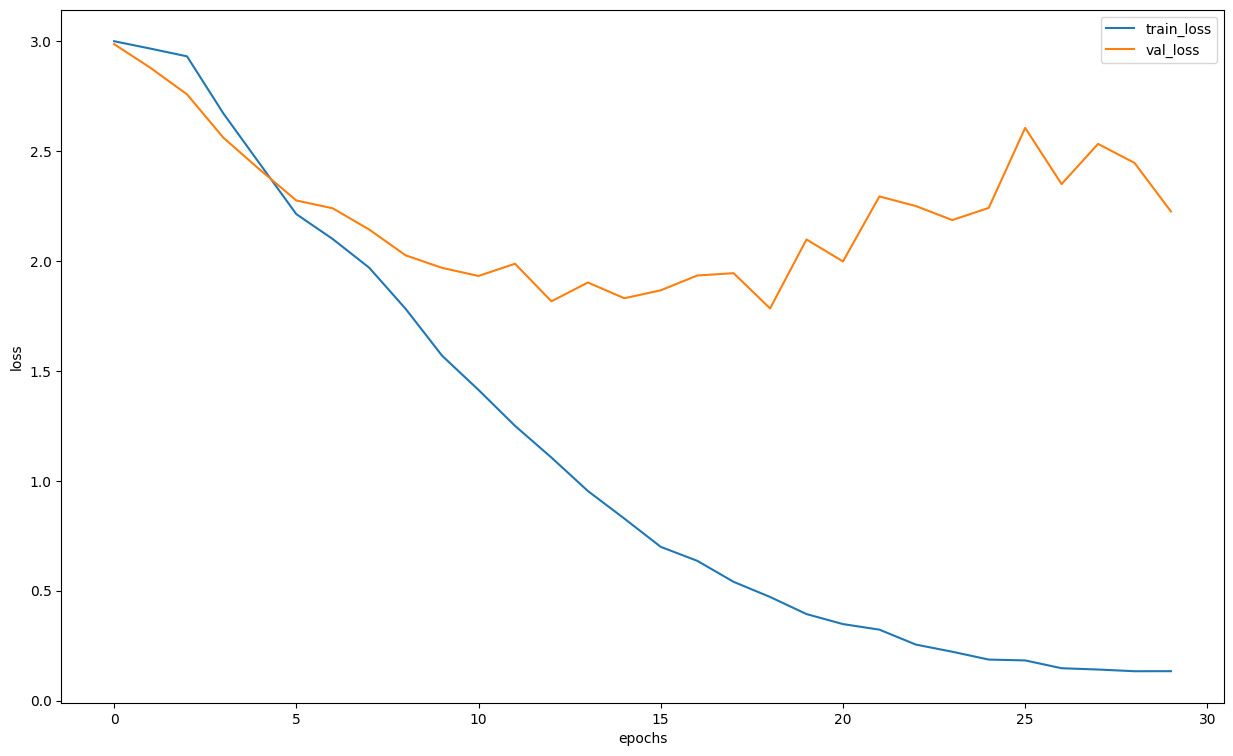

In [53]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()